Required imports and creating train/test pandas dataframes:

In [1]:

import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename == "toxic_test.csv":
            test_df = pd.read_csv(os.path.join(dirname,filename))
        elif filename == "toxic_train.csv":
            train_df = pd.read_csv(os.path.join(dirname,filename))


# Basic EDA
Few examples of non-toxic and toxic speech.

**Non-Toxic Text Examples:**

In [2]:

print(train_df[train_df["toxic"] == 0]["comment_text"].values[0])
print("\n")
print(train_df[train_df["toxic"] == 0]["comment_text"].values[1])
print("\n")
print(train_df[train_df["toxic"] == 0]["comment_text"].values[2])
print("\n")
print(train_df[train_df["toxic"] == 0]["comment_text"].values[3])
print("\n")
print(train_df[train_df["toxic"] == 0]["comment_text"].values[4])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)


Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.


"
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or

**Toxic Text Examples:**

In [3]:
print(train_df[train_df["toxic"] == 1]["comment_text"].values[0])
print("\n")
print(train_df[train_df["toxic"] == 1]["comment_text"].values[1])
print("\n")
print(train_df[train_df["toxic"] == 1]["comment_text"].values[2])
print("\n")
print(train_df[train_df["toxic"] == 1]["comment_text"].values[3])
print("\n")
print(train_df[train_df["toxic"] == 1]["comment_text"].values[4])

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK


Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


Bye! 

Don't look, come or think of comming back! Tosser.


You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would wri

Looking at some trends throughout the training dataset:

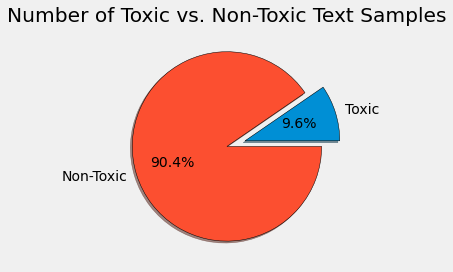

In [4]:
from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight')

tot = train_df.shape[0]
num_toxic = train_df[train_df.toxic == 1].shape[0]

slices = [num_toxic/tot,(tot - num_toxic)/tot]
labeling = ['Toxic','Non-Toxic']
explode = [0.2,0]
plt.pie(slices,explode=explode,shadow=True,autopct='%1.1f%%',labels=labeling,wedgeprops={'edgecolor':'black'})
plt.title('Number of Toxic vs. Non-Toxic Text Samples')
plt.tight_layout()
plt.show()



So the dataset is clearly biased towards non-toxic comments.

# Vectorizing Text
Using scikit-learn's CountVectorizer to vectorize each comment, whereby each word gets assigned to a numerical index, throwing away any word that occurs in more than 25% of the comments as well as any word that occurs less than 5 times

In [5]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

cv1 = feature_extraction.text.CountVectorizer(max_df=0.25)
cv1.fit_transform(train_df["comment_text"])

print("%i words discarded for occurring too frequently:" %(len(cv1.stop_words_)))
print(cv1.stop_words_)

cv2 = feature_extraction.text.CountVectorizer(min_df=5)
cv2.fit_transform(train_df["comment_text"])

print("%i words discarded for occurring too infrequently:" %(len(cv2.stop_words_)))
print(list(cv2.stop_words_)[0:20])

count_vectorizer = feature_extraction.text.CountVectorizer(max_df=0.25, min_df=5)
train_vectors = count_vectorizer.fit_transform(train_df["comment_text"])

print("There are %i words in this corpus" %(train_vectors.shape[1]))


17 words discarded for occurring too frequently:
{'on', 'not', 'to', 'in', 'of', 'this', 'you', 'as', 'it', 'the', 'that', 'be', 'are', 'is', 'for', 'have', 'and'}
153525 words discarded for occurring too infrequently:
['resedrved', 'babi', 'kinfra', 'kundalini', 'perrot', 'virtus', '11by', 'bulcsú', 'antisymmetric', 'erinnerungeu', 'antya', 'chingching', 'pucks', 'husayni', 'miser', 'dirknelson', 'azz', 'ply', 'roman_empire', 'safeguards']
There are 36233 words in this corpus


In [6]:
from sklearn.metrics import f1_score

clf = linear_model.RidgeClassifier().fit(train_vectors, train_df["toxic"])
print("Percent correctly labeled comments by Ridge Classifier:")
print(clf.score(train_vectors, train_df["toxic"]))

print("f1 score for non-toxic comments:")
print(f1_score(train_df["toxic"],clf.predict(train_vectors),pos_label=0))

print("f1 score for toxic comments:")
print(f1_score(train_df["toxic"],clf.predict(train_vectors),pos_label=1))


Percent correctly labeled comments by Ridge Classifier:
0.9365924886100858
f1 score for non-toxic comments:
0.9660287402632286
f1 score for toxic comments:
0.5250211247770161


Although 93.6% correctly labeled might look good, most naive classifier would have 90% accuracy. More important criteria here is  the f1 score for both classes

In [7]:
predict_toxic = clf.predict(train_vectors)
error1 = []
error2 = []
for i in range(len(predict_toxic)):
    prediction = predict_toxic[i]
    actual = train_df.iloc[i, 2]
    if prediction == 0 and actual == 1 and len(error1) < 5:
        error1.append(train_df.iloc[i,1])
    elif prediction == 1 and actual == 0 and len(error2) < 5:
        error2.append(train_df.iloc[i,1])

print("Toxic comments incorrectly labeled as Non-Toxic comments: ")
print("\n")
for comment in error1:
    print(comment)
    print("-"*120)
    
print("Non-Toxic comments incorrectly labeled as Toxic comments: ")
print("\n")
for comment in error2:
    print(comment)
    print("-"*120)
    

Toxic comments incorrectly labeled as Non-Toxic comments: 


Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...
------------------------------------------------------------------------------------------------------------------------
Bye! 

Don't look, come or think of comming back! Tosser.
------------------------------------------------------------------------------------------------------------------------
FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
------------------------------------------------------------------------------------------------------------------------
I'm Sorry 

I'm sorry I screwed around with someones talk page.  It was very bad to do.  I know how having the templates on their talk page helps you assert 

Taking a look at which words contribute to the classifier labeling toxic vs. non-toxic comments:

In [8]:
n = 25
idx_max = (-clf.coef_).argsort()

print("Most 'toxic' words:")
for i in range(n):
    num = idx_max[0][i]
    print(count_vectorizer.get_feature_names()[num])

    
idx_min = (clf.coef_).argsort()
print("\n")
print("Most 'non-toxic' words:")
for i in range(n):
    num = idx_min[0][i]
    print(count_vectorizer.get_feature_names()[num])
    

Most 'toxic' words:
areaseven
fashist
donkeys
bullshits
ungraceful
andrex
shadeed
kikes
fuckhead
fucktard
butthole
fuckstick
chode
jerkoff
sieg
fuckwit
shitbag
ure
lyoko
mattythewhite
dumbfuck
provocateur
avenge
adage
caus


Most 'non-toxic' words:
spotty
kamehameha
tore
dustbin
mothjer
giggling
aristocrats
unfettered
pinky
bitchass
infidels
heartbeat
swollen
rots
rube
amadeus
eject
cker
tricking
wikipedea
ilchee
clam
heater
saliva
angela


So we can see that some non-toxic words snuck into the toxic word list and vice versa.

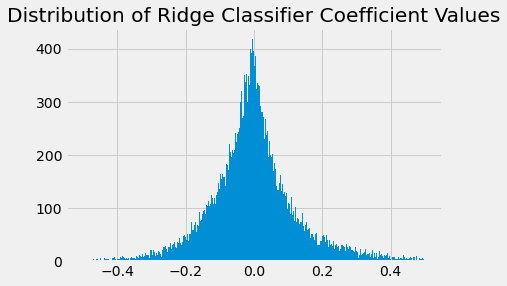

Percentage of words with a positive (leaning towards toxic) coefficient:
0.470372312532774
Percentage of words with a negative (leaning towards non-toxic) coefficient:
0.529627687467226


In [9]:

plt.hist(clf.coef_[0,:],bins=500,range=[-0.5,0.5])
plt.title("Distribution of Ridge Classifier Coefficient Values")
plt.show()

pos = len(clf.coef_[clf.coef_ > 0])

tot = len(clf.coef_[0,:])

toxic_leaning = pos/tot
non_toxic_leaning = 1 - toxic_leaning

print("Percentage of words with a positive (leaning towards toxic) coefficient:")
print(toxic_leaning)

print("Percentage of words with a negative (leaning towards non-toxic) coefficient:")
print(non_toxic_leaning)

> # TF-IDF

Now, doing a very similar classification, but instead of CountVectorizer, construct a matrix of Tf-Idf features.


In [10]:

count_vectorizer = feature_extraction.text.TfidfVectorizer(max_df=0.25, min_df=5)
train_vectors = count_vectorizer.fit_transform(train_df["comment_text"])

print("There are %i words in this corpus" %(train_vectors.shape[1]))

clf = linear_model.RidgeClassifier().fit(train_vectors, train_df["toxic"])
print("Percent correctly labeled comments by Ridge Classifier:")
print(clf.score(train_vectors, train_df["toxic"]))

print("f1 score for non-toxic comments:")
print(f1_score(train_df["toxic"],clf.predict(train_vectors),pos_label=0))

print("f1 score for toxic comments:")
print(f1_score(train_df["toxic"],clf.predict(train_vectors),pos_label=1))

There are 36233 words in this corpus
Percent correctly labeled comments by Ridge Classifier:
0.9632389343928408
f1 score for non-toxic comments:
0.9800130838319272
f1 score for toxic comments:
0.7713060428849902


Markedly better than CountVectorizer.

In [11]:
predict_toxic = clf.predict(train_vectors)
error1 = []
error2 = []
for i in range(len(predict_toxic)):
    prediction = predict_toxic[i]
    actual = train_df.iloc[i, 2]
    if prediction == 0 and actual == 1 and len(error1) < 5:
        error1.append(train_df.iloc[i,1])
    elif prediction == 1 and actual == 0 and len(error2) < 5:
        error2.append(train_df.iloc[i,1])

print("Toxic comments incorrectly labeled as Non-Toxic comments: ")
print("\n")
for comment in error1:
    print(comment)
    print("-"*120)
    
print("Non-Toxic comments incorrectly labeled as Toxic comments: ")
print("\n")
for comment in error2:
    print(comment)
    print("-"*120)

Toxic comments incorrectly labeled as Non-Toxic comments: 


Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...
------------------------------------------------------------------------------------------------------------------------
Bye! 

Don't look, come or think of comming back! Tosser.
------------------------------------------------------------------------------------------------------------------------
I'm Sorry 

I'm sorry I screwed around with someones talk page.  It was very bad to do.  I know how having the templates on their talk page helps you assert your dominance over them.  I know I should bow down to the almighty administrators.  But then again, I'm going to go play outside....with your mom.   76.122.79.82

In [12]:
n = 25
idx_max = (-clf.coef_).argsort()

print("Most 'toxic' words:")
for i in range(n):
    num = idx_max[0][i]
    print(count_vectorizer.get_feature_names()[num])

    
idx_min = (clf.coef_).argsort()
print("\n")
print("Most 'non-toxic' words:")
for i in range(n):
    num = idx_min[0][i]
    print(count_vectorizer.get_feature_names()[num])

Most 'toxic' words:
idiot
bullshit
stupid
idiots
crap
morons
idiotic
fuck
moron
sucks
shit
dumbass
pathetic
fucked
stupidity
bitching
hypocrite
jerk
penis
assholes
niggers
jackass
ck
fuckhead
pervert


Most 'non-toxic' words:
joshuaz
nambla
dads
aquaman
callin
habitual
embarrassment
sapiens
wannabes
complains
witless
prejudiced
unfettered
rube
sponsered
knee
carbuncle
pontificate
contracted
insanity
rango
weirdest
deletin
sniping
cradle


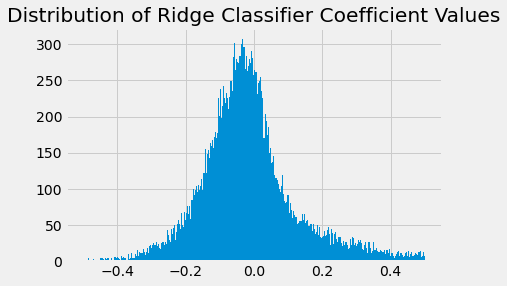

Percentage of words with a positive (leaning towards toxic) coefficient:
0.40719785830596417
Percentage of words with a negative (leaning towards non-toxic) coefficient:
0.5928021416940359


In [13]:

plt.hist(clf.coef_[0,:],bins=500,range=[-0.5,0.5])
plt.title("Distribution of Ridge Classifier Coefficient Values")
plt.show()

pos = len(clf.coef_[clf.coef_ > 0])

tot = len(clf.coef_[0,:])

toxic_leaning = pos/tot
non_toxic_leaning = 1 - toxic_leaning

print("Percentage of words with a positive (leaning towards toxic) coefficient:")
print(toxic_leaning)

print("Percentage of words with a negative (leaning towards non-toxic) coefficient:")
print(non_toxic_leaning)

The tail for the positive end of the distribution has grown fatter; this means that this model has actually found more words that surely must be toxic, as opposed to before where the vast majority of words were somewhat toxic and somewhat non-toxic. 

# RNN


In [23]:
import torch   
from torchtext import data

train_path = '/kaggle/input/hate-speech-detection/toxic_train.csv'
test_path = '/kaggle/input/hate-speech-detection/toxic_test.csv'

TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [('', None), ('comment_text',TEXT),('toxic', LABEL)]

training_data=data.TabularDataset(path = train_path,format = 'csv',fields = fields,skip_header = True)
print(vars(training_data.examples[0]))


{'comment_text': ['Explanation', '\n', 'Why', 'the', 'edits', 'made', 'under', 'my', 'username', 'Hardcore', 'Metallica', 'Fan', 'were', 'reverted', '?', 'They', 'were', "n't", 'vandalisms', ',', 'just', 'closure', 'on', 'some', 'GAs', 'after', 'I', 'voted', 'at', 'New', 'York', 'Dolls', 'FAC', '.', 'And', 'please', 'do', "n't", 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'I', "'m", 'retired', 'now.89.205.38.27'], 'toxic': '0'}


In [24]:
import random
train_data, valid_data = training_data.split(split_ratio=0.7)

#initialize glove embeddings
TEXT.build_vocab(train_data,min_freq=3)  
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
#print(TEXT.vocab.stoi)  

Size of TEXT vocabulary: 63836
Size of LABEL vocabulary: 2
[('.', 360950), (',', 330153), ('the', 313888), ('"', 266552), ('to', 203745), ('I', 157506), ('of', 154450), ('and', 147927), ('a', 142074), ('you', 127264)]


In [25]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(device)

#set batch size
BATCH_SIZE = 400

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.comment_text),
    sort_within_batch=True,
    device = device)

cuda


In [26]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs

In [27]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)

In [28]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [29]:
from tqdm import tqdm_notebook as tqdm

def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    accs = []
    losses = []
    batches = []
    
    #set the model in training phase
    model.train()  
    
    batch_num = 0
    
    for batch in tqdm(iterator):
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.comment_text   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.toxic)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.toxic)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()
        
        losses.append(loss.item())
        accs.append(acc.item())
        batches.append(batch_num)
        
        batch_num += 1
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), losses, accs, batches

In [30]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0
    
    losses = []
    accs = []
    batches = []

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
        
        batch_num = 0
    
        for batch in iterator:
            
        
            #retrieve text and no. of words
            text, text_lengths = batch.comment_text
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.toxic)
            acc = binary_accuracy(predictions, batch.toxic)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            losses.append(loss.item())
            accs.append(acc.item())
            batches.append(batch_num)
            batch_num += 1
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), losses, accs, batches

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


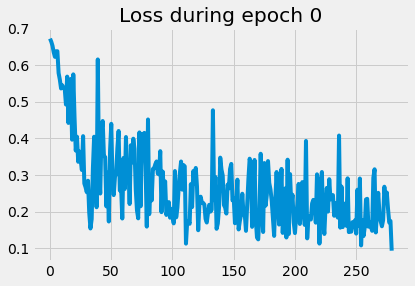

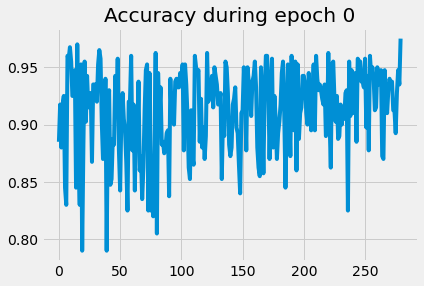

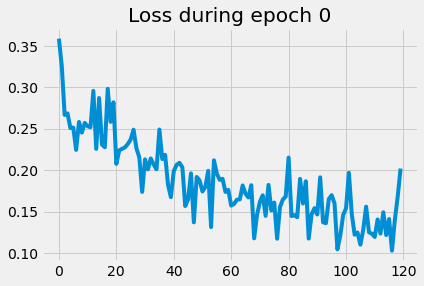

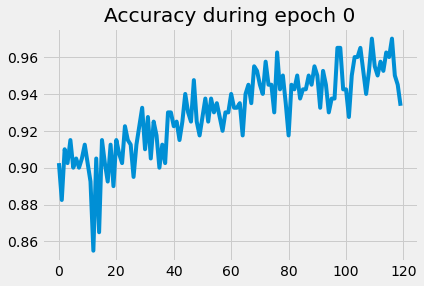

	Train Loss: 0.271 | Train Acc: 91.24%
	 Val. Loss: 0.186 |  Val. Acc: 93.01%


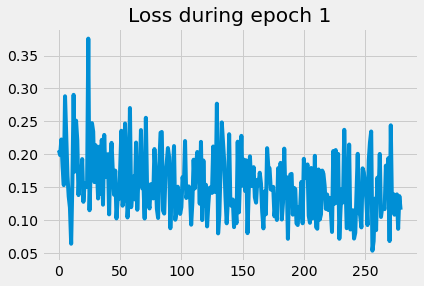

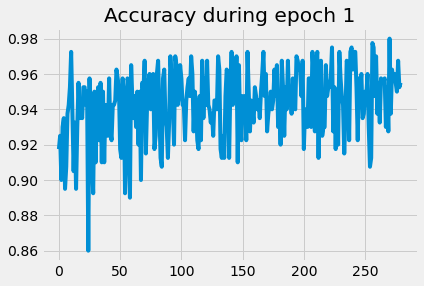

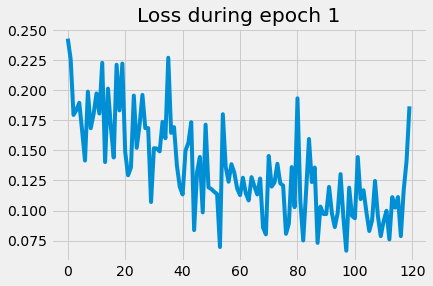

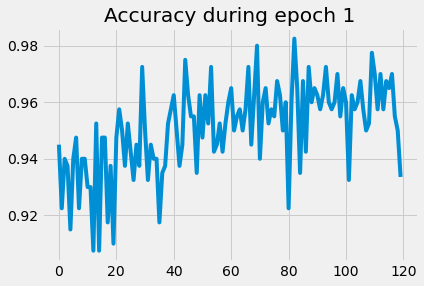

	Train Loss: 0.153 | Train Acc: 94.34%
	 Val. Loss: 0.135 |  Val. Acc: 95.10%


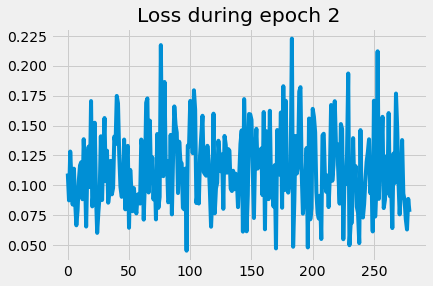

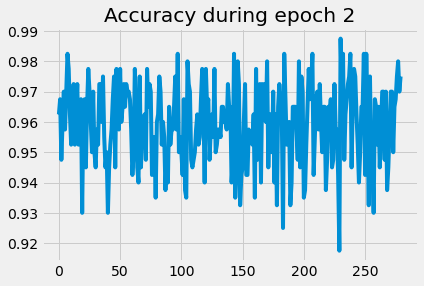

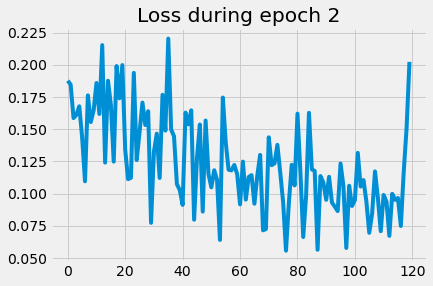

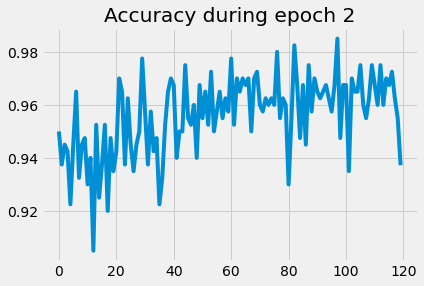

	Train Loss: 0.113 | Train Acc: 95.94%
	 Val. Loss: 0.125 |  Val. Acc: 95.61%


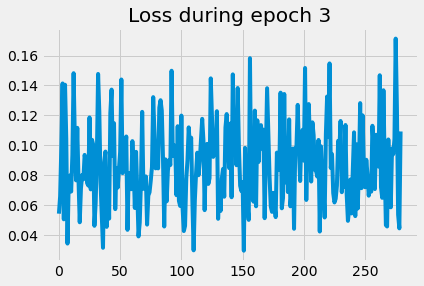

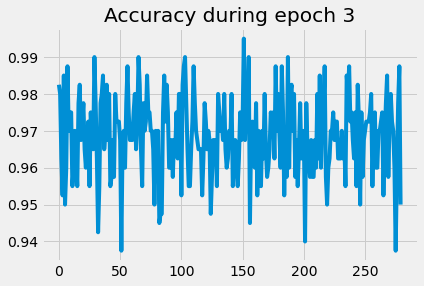

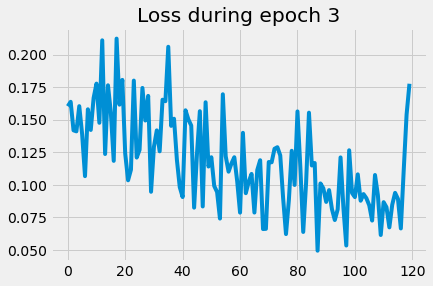

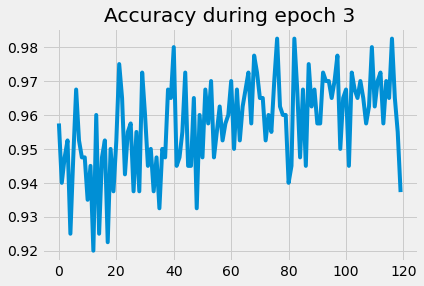

	Train Loss: 0.088 | Train Acc: 96.85%
	 Val. Loss: 0.119 |  Val. Acc: 95.74%


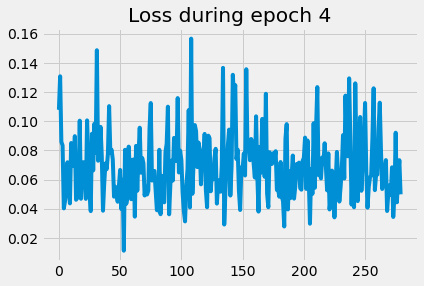

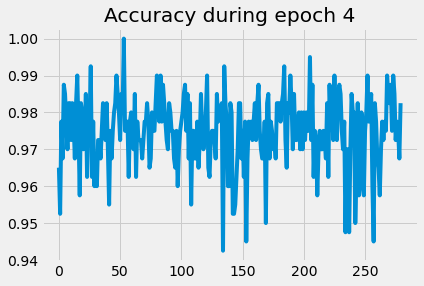

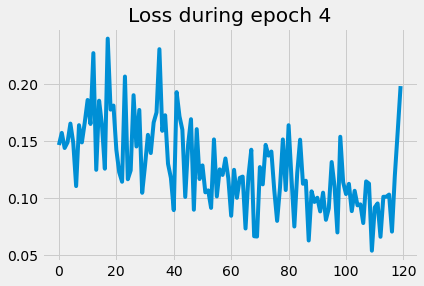

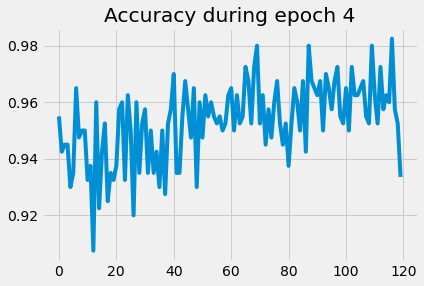

	Train Loss: 0.070 | Train Acc: 97.48%
	 Val. Loss: 0.128 |  Val. Acc: 95.33%


In [31]:
N_EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc, losses, accs, batches = train(model, train_iterator, optimizer, criterion)
    
    plt.plot(batches, losses)
    plt.title("Loss during epoch %i" %(epoch))
    plt.show()
    
    plt.plot(batches, accs)
    plt.title("Accuracy during epoch %i" %(epoch))
    plt.show()
    
    #evaluate the model
    valid_loss, valid_acc, losses, accs, batches = evaluate(model, valid_iterator, criterion)
    
    plt.plot(batches, losses)
    plt.title("Loss during epoch %i" %(epoch))
    plt.show()
    
    plt.plot(batches, accs)
    plt.title("Accuracy during epoch %i" %(epoch))
    plt.show()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')